# project description:

- the goal of the  project is to  help optimize marketing expenses by the study of how pepole use the  product,how much users are buying and what is the amont of money  each user brings

- also when does markting expenses payoff(romi)  on which sales platform to invest more in order to increase revenue



In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
visits=pd.read_csv('/Users/adiel/Downloads/visits_log_us.csv',dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],)
orders= pd.read_csv('/Users/adiel/Downloads/orders_log_us.csv',parse_dates=['Buy Ts'])
expenses = pd.read_csv('/Users/adiel/Downloads/costs_us.csv',parse_dates=['dt'])

In [137]:
visits = visits.rename(columns=str.lower)

In [138]:
orders = orders.rename(columns=str.lower)

In [139]:
expenses.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [140]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end ts     359400 non-null  datetime64[ns]
 2   source id  359400 non-null  int64         
 3   start ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [141]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [142]:
visits.describe()


,source id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [143]:
#checking for missing values
visits.isnull().sum()

device       0
end ts       0
source id    0
start ts     0
uid          0
dtype: int64

In [144]:
# checking for duplicates
visits.duplicated().sum()

0

#### 1 data download:
Each data frame has a number of different lines. I replace the uppercase letters of the column names in lowercase
And changed the date format in all the needed data frames


In [145]:
# adding dates columns
visits['week'] = visits['start ts'].astype('datetime64[W]')
visits['month'] = visits['start ts'].astype('datetime64[M]')
visits['day'] = visits['start ts'].astype('datetime64[D]')
visits['day_end'] = visits['end ts'].astype('datetime64[D]')
visits['time_app_sec'] = (visits['end ts'] - visits['start ts']).dt.seconds

In [146]:
visits.head()

,device,end ts,source id,start ts,uid,week,month,day,day_end,time_app_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-14,2017-12-01,2017-12-20,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-15,2018-02-01,2018-02-19,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-06-29,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-17,2018-05-01,2018-05-20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-21,2017-12-01,2017-12-27,2017-12-27,0


In [147]:
print(visits[visits['time_app_sec']== 0].shape[0])
print(visits[(visits['start ts']) > (visits['end ts'])].shape[0])

35794
2


In [148]:
# checking if there are action where start date > end date
visits[(visits['start ts']) > (visits['end ts'])]

,device,end ts,source id,start ts,uid,week,month,day,day_end,time_app_sec
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,2018-03-22,2018-03-01,2018-03-25,2018-03-25,84480
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,2018-03-22,2018-03-01,2018-03-25,2018-03-25,83640


In [149]:
#droping actions
visits.drop([4181,177972], axis=0, inplace=True)

----- I found that 2 users that in the same session  had a larger end date than  start date because it did not make sense I drop the lines

In [155]:
visits_=visits
visits_.shape

(359398, 10)

In [156]:
# min ans ,ax date in the data
print(visits_['start ts'].min())
print(visits_['start ts'].max())

2017-06-01 00:01:00
2018-05-31 23:59:00


In [157]:
# adding first dates columns to the data
vis_group = visits_.groupby('uid')['start ts'].min()
vis_group.name = 'first_date'
visits_ = visits_.join(vis_group, on='uid')
vis_group = visits_.groupby('uid')['month'].min()
vis_group.name = 'first'
visits_ = visits_.join(vis_group, on='uid')
wee_group = visits_.groupby('uid')['week'].min()
wee_group.name = 'first_week'
visits_ = visits_.join(wee_group, on='uid')
visits_.head()

,device,end ts,source id,start ts,uid,week,month,day,day_end,time_app_sec,first_date,first,first_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-14,2017-12-01,2017-12-20,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-14
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-15,2018-02-01,2018-02-19,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-15
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-06-29,2017-07-01,2017-07-01,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-06-29
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-17,2018-05-01,2018-05-20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-03-08
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-21,2017-12-01,2017-12-27,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-21


In [158]:
visits_['cohort_lifetime'] = visits_['month'] - visits_['first'] 
visits_['cohort_lifetime'] = visits_['cohort_lifetime'] / np.timedelta64(1, 'M')
visits_['cohort_lifetime'] = visits_['cohort_lifetime'].astype(int)
visits_['cohort_week'] = visits_['week'] - visits_['first_week'] 
visits_['cohort_week'] = visits_['cohort_week'] / np.timedelta64(1, 'W')
visits_['cohort_week'] = visits_['cohort_week'].astype(int)
visits_.head()

,device,end ts,source id,start ts,uid,week,month,day,day_end,time_app_sec,first_date,first,first_week,cohort_lifetime,cohort_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-14,2017-12-01,2017-12-20,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-14,0,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-15,2018-02-01,2018-02-19,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-15,0,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-06-29,2017-07-01,2017-07-01,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-06-29,0,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-17,2018-05-01,2018-05-20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-03-08,2,10
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-21,2017-12-01,2017-12-27,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-21,0,0


In [159]:
visits_['sticki_year']  = visits_['start ts'].dt.year
visits_['sticki_month'] = visits_['start ts'].dt.month
visits_['sticki_week']  = visits_['start ts'].dt.isocalendar().week
visits_['sticki_date'] = visits_['start ts'].dt.date

In [160]:
month_group = visits_.groupby('month').agg({'uid' : 'nunique'}).sort_values(by='uid',ascending=False).head(10)
print(month_group['uid'].mean())
month_group

25385.1


,uid
month,
2017-11-01,32797
2017-12-01,31557
2017-10-01,29692
2018-02-01,28749
2018-01-01,28716
2018-03-01,27473
2018-04-01,21008
2018-05-01,20701
2017-09-01,18975


In [161]:
week_group = visits_.groupby('week').agg({'uid' : 'nunique'})
print(week_group['uid'].mean())
print(week_group.sort_values(by='uid',ascending=False).head(10))

5724.415094339623
              uid
week             
2017-11-23  10716
2017-12-07   8575
2018-03-22   8486
2017-11-16   8294
2018-02-08   8218
2017-11-30   8122
2018-02-01   8016
2018-02-15   7639
2017-10-26   7638
2017-12-14   7611


In [162]:
day_group = visits_.groupby('day').agg({'uid' : 'nunique'})
print(day_group['uid'].mean())
print(day_group.sort_values(by='uid',ascending=False).head(10))

907.9917582417582
             uid
day             
2017-11-24  3319
2018-05-31  1997
2017-11-25  1817
2018-02-01  1640
2018-03-26  1609
2017-11-16  1604
2017-11-27  1571
2018-03-27  1551
2018-03-25  1545
2017-12-07  1524


# user

- we have 23228 everge monthly user with the most active month were 12,11-2017 

- we have 5724 everge monthly user with the most active weeks  were also in 12,11-2017 

-  we have 907 everge daily user 

In [131]:

def session(x):
    back_user = x.groupby(['sticki_year', 'sticki_month']).agg({'uid': ['count', 'nunique']})
    back_user.columns = ['num_sessions', 'count_users']
    back_user['sessions_per_user'] = back_user['num_sessions'] / back_user['count_users']
    print('the average sessions_per_user', back_user['sessions_per_user'].mean())
    print(back_user)
print('all users')
session(visits_)
print('-----------')
print('desktop users')
session(visits_[visits_['device']=='desktop'])
print('------------')
print('touch users')
session(visits_[visits_['device']=='touch'])
print('----------')        
      

all users
the average sessions_per_user 1.280883428036945
                          num_sessions  count_users  sessions_per_user
sticki_year sticki_month                                              
2017        6                    16505        13259           1.244815
            7                    17828        14183           1.256998
            8                    14355        11631           1.234202
            9                    23907        18975           1.259921
            10                   37903        29692           1.276539
            11                   43969        32797           1.340641
            12                   41983        31557           1.330386
2018        1                    36939        28716           1.286356
            2                    37182        28749           1.293332
            3                    35677        27473           1.298620
            4                    26515        21008           1.262138
            5      

# sessions_per_user

- the everge sessions count for all users is 1.2
 
- the everge sessions count for all users that use desktop is 1.3

-  the everge sessions count for all users that use touch is 1.17
- It can be seen that the average is similar in everyone most people use the platform once

all users
                               sessions  sessions_t
day        uid                                     
2017-06-01 32197920403662046          1         120
           184148767273119549         2        1920
           254239507810036143         1         240
           258099436367309303         1        8760
           300776506671194537         1         240
the everge minte time is: 11.65415122331515
mode: 0    60
dtype: int64
-----------
desktop users
                               sessions  sessions_t
day        uid                                     
2017-06-01 32197920403662046          1         120
           184148767273119549         2        1920
           254239507810036143         1         240
           258099436367309303         1        8760
           300776506671194537         1         240
the everge minte time is: 12.82583751797137
mode: 0    60
dtype: int64
------------
touch users
                                sessions  sessions_t
day        uid  

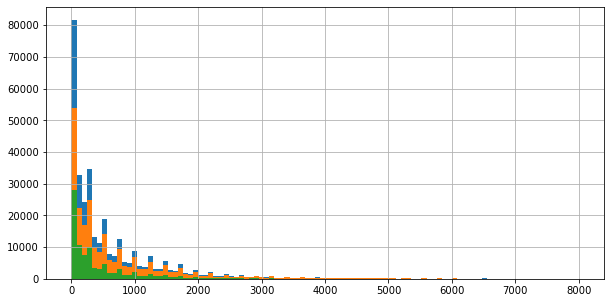

In [163]:
# avarge users session and app time
def time(x):  
    sec_group = x.groupby(['day','uid']).agg({'uid' : 'count', 'time_app_sec' : 'sum'})
    sec_group.columns = ['sessions','sessions_t']
    print(sec_group.head())
    print('the everge minte time is:',sec_group['sessions_t'].mean() / 60)
    print('mode:',sec_group['sessions_t'].mode())
    sec_group['sessions_t'].hist(bins=100,range=(0,8000))
plt.figure(figsize=(10, 5))  
print('all users')
time(visits_)
print('-----------')
print('desktop users')
time(visits_[visits_['device']=='desktop'])
print('------------')
print('touch users')
time(visits_[visits_['device']=='touch'])
print('----------')    

# session time

- the everge session time is 11.6 mintes,desktop users session time is longer and touch session time is shorter

- touch users spend less time in the app 



Text(0.5, 1.0, 'touch users month retention')

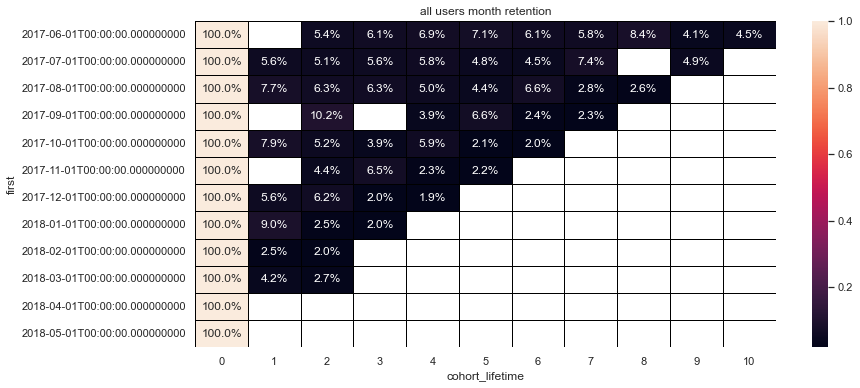

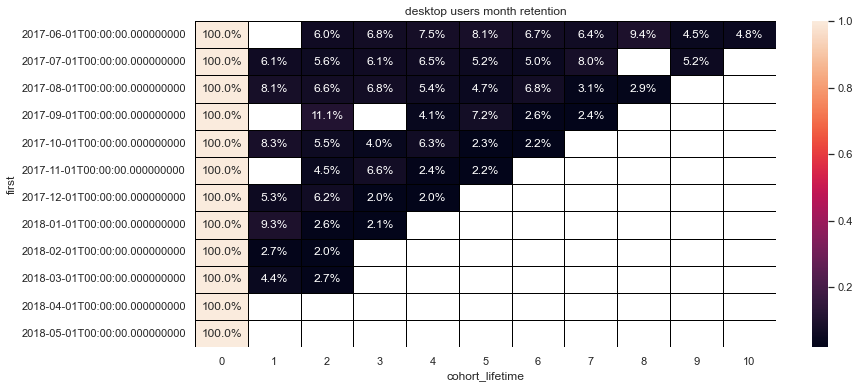

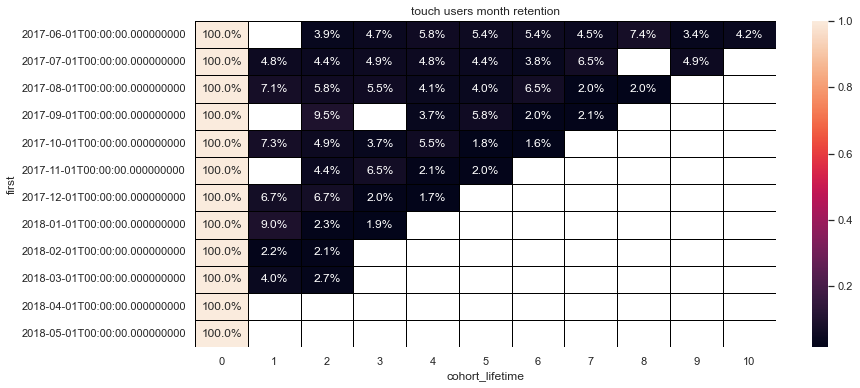

In [168]:
# users app retention
def rate(x):
    rate1 = (x.groupby(['first', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index())
    users_count = rate1[rate1['cohort_lifetime'] == 0][['first', 'uid']]
    users_count = users_count.rename(columns={'uid': 'users_t'}) 
    rate1 = rate1.merge(users_count, on='first')
    rate1['ret'] = rate1['uid'] / rate1['users_t']
    month_retention = rate1.pivot_table(index='first',columns='cohort_lifetime',values='ret',aggfunc='sum',)    
    sns.set(style='white')
    plt.figure(figsize=(13, 6))    
    sns.heatmap(month_retention, annot=True, fmt='.1%', linewidths=1, linecolor='black');
   
    
rate(visits_)
plt.title('all users month retention')
rate(visits_[visits_['device']=='desktop'])
plt.title('desktop users month retention')
rate(visits_[visits_['device']=='touch'])
plt.title('touch users month retention')

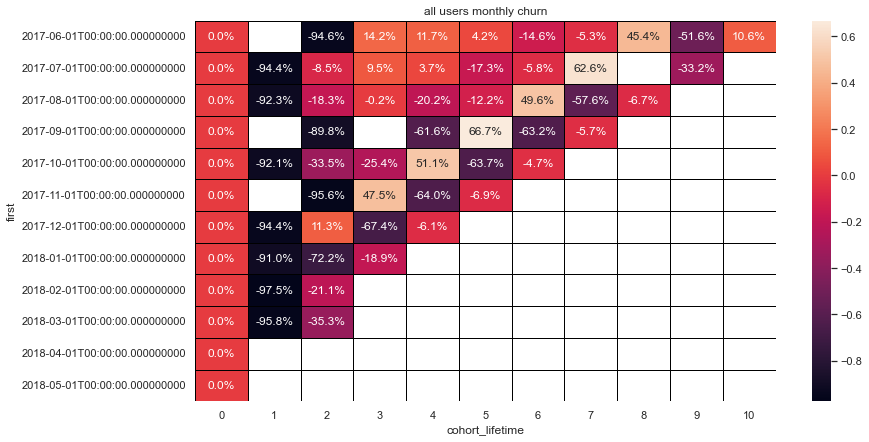

In [167]:
# users chun
rate1 = (visits_.groupby(['first', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index())
rate1['churn'] = rate1.groupby(['first'])['uid'].pct_change() 
churn_month = rate1.pivot_table(index='first',columns='cohort_lifetime',values='churn',aggfunc='sum')
plt.figure(figsize=(13, 7))
sns.heatmap(churn_month, annot=True, fmt='.1%', linewidths=1, linecolor='black')
plt.title('all users monthly churn');

In [169]:
week_rate = visits_.query('day > "2017-10-01" and day < "2018-01-01"')
rate2 = (week_rate.groupby(['first_week', 'cohort_week']).agg({'uid': 'nunique'}).reset_index())
users_counts = rate2[rate2['cohort_week'] == 0][['first_week', 'uid']]
users_counts = users_counts.rename(columns={'uid': 'users_to'})  
rate2 = rate2.merge(users_counts, on='first_week')
rate2
rate2['ret_week'] = rate2['uid'] / rate2['users_to']
week_retention = rate2.pivot_table(index='first_week',columns='cohort_week',values='ret_week',aggfunc='sum',)
rate2['churn'] = rate2.groupby(['first_week'])['uid'].pct_change() 
churn_week = rate2.pivot_table(index='first_week',columns='cohort_week',values='churn',aggfunc='sum',)

Text(0.5, 1.0, 'all users weekly churn')

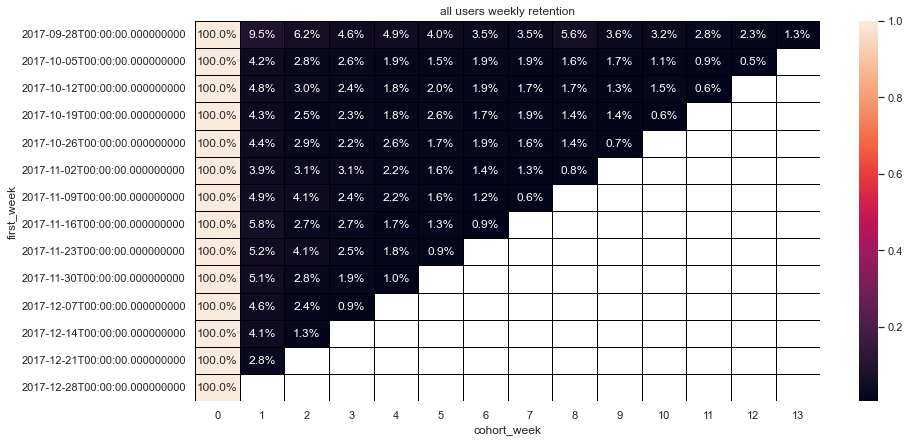

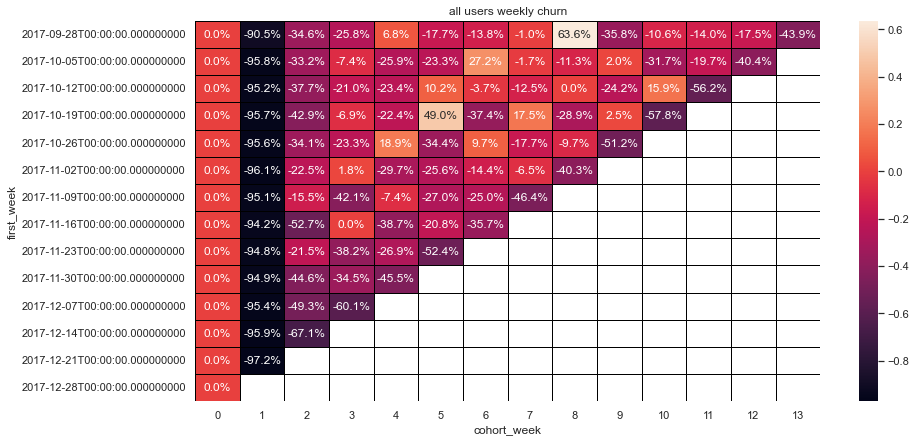

In [170]:
def heat(x):   
    plt.figure(figsize=(14, 7))
    sns.heatmap( x, annot=True, fmt='.1%', linewidths=1, linecolor='black')
heat(week_retention)
plt.title('all users weekly retention')
heat(churn_week)
plt.title('all users weekly churn')

In [171]:
dau_total = visits_.groupby('sticki_date').agg({'uid': 'nunique'}).mean()
wau_total = visits_.groupby(['sticki_year', 'sticki_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits_.groupby(['sticki_year', 'sticki_month']).agg({'uid': 'nunique'}).mean()

print('dau',int(dau_total))
print('wau',int(wau_total)) 
print('mau',int(mau_total))
print('-----------------')
print('week rate',dau_total / wau_total*100)
print('month rate',dau_total / mau_total*100)

dau 907
wau 5716
mau 23228
-----------------
week rate uid    15.884409
dtype: float64
month rate uid    3.90897
dtype: float64


# user retention

- the retention rate shows that After the first month the ratio of users drops drastically and it does not rise back it is valid for all users and there are also similar results by the differnts divide the data by devices,

- I also checked the ratio in a period of 3 months by weeks and also there you see that after the first week very few customers return to the product

- the sticki monthly rate shows the same result only 3 precentage of the users return after the first month its very low


In [172]:
desktop_group = visits_.query('device=="desktop"').groupby('month').agg({'uid':'nunique'}).reset_index()
touch_group = visits_.query('device=="touch"').groupby('month').agg({'uid':'nunique'}).reset_index()

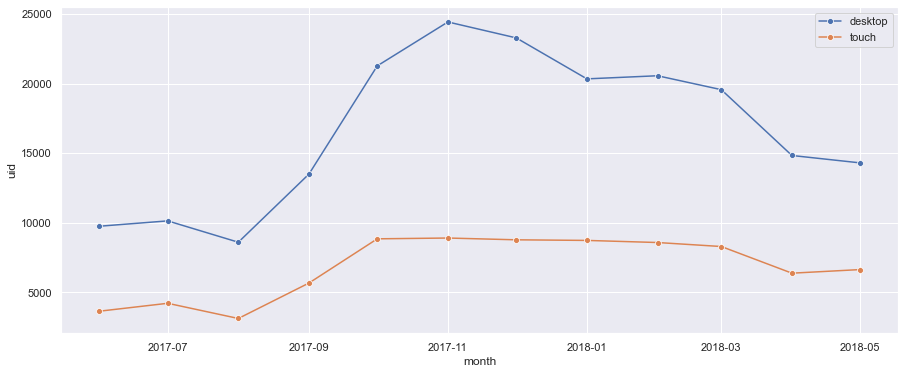

In [174]:
#plot Displays how many users there are in each device over time
sns.set_style("darkgrid")
plt.figure(figsize=(15,6))
sns.lineplot(data=desktop_group, x='month',ci=41,y='uid',label='desktop', marker="o")
sns.lineplot(data=touch_group, x='month',ci=41,y='uid',label='touch', marker="o");

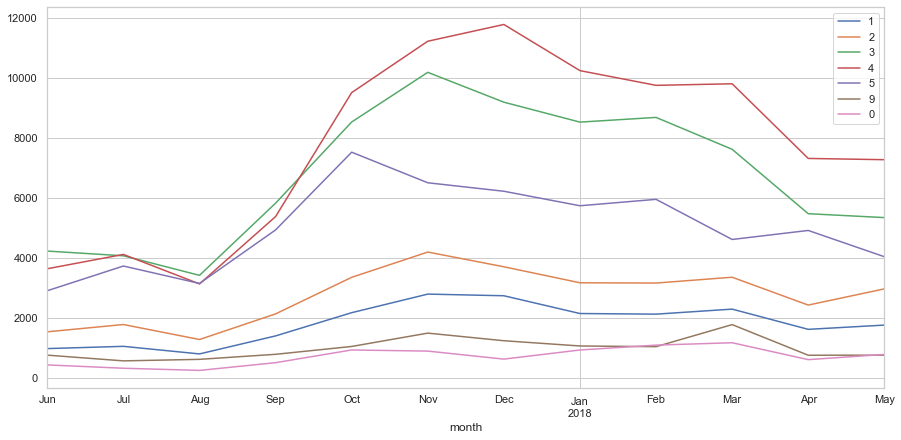

In [175]:
# how much users came from each source
def source(x):
        count_group_ = x.groupby(['month']).agg({'uid': 'nunique'}).reset_index()    
    count_group_.plot(x='month',y='uid' ,kind='line',ax=ax)
    ax.legend('1234590') 
sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
ax =plt.gca()
ax.legend('12345910')    
source(visits_[visits_['source id']==1])
source(visits_[visits_['source id']==2])
source(visits_[visits_['source id']==3])
source(visits_[visits_['source id']==4])
source(visits_[visits_['source id']==5])
source(visits_[visits_['source id']==9])
source(visits_[visits_['source id']==10])   

             uid
source id       
1          18999
2          26245
3          74756
4          83525
5          56974
6              6
7             34
9           9264
10          8067


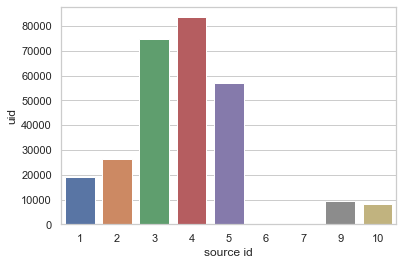

In [179]:
devs_group = visits_.groupby('source id').agg({'uid' : 'nunique'})
print(devs_group)
sns.barplot(data=devs_group.reset_index(),x='source id',y='uid',ci=89);

- most off the users reach the platform by source 3,4,5,

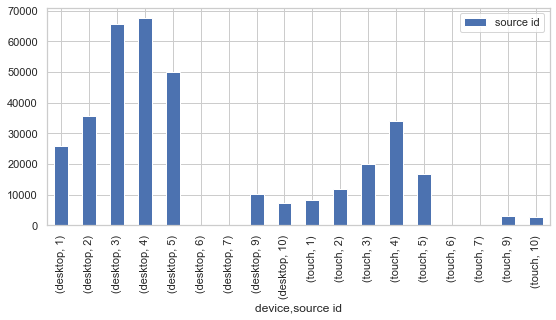

In [178]:
k_table=  visits_.groupby(['device','source id']).agg({'source id': 'count'})
k_table.plot(kind='bar',figsize=(9,4));

# 2 sales 

In [180]:
dict_ = dict(zip(visits_['uid'],visits_['source id']))

In [182]:
visits_group= visits_.pivot_table(index=['uid','first_date'],values='time_app_sec',aggfunc='sum').reset_index()
visits_group.head()

,uid,first_date,time_app_sec
0,11863502262781,2018-03-01 17:27:00,360
1,49537067089222,2018-02-06 15:55:00,120
2,297729379853735,2017-06-07 18:47:00,60
3,313578113262317,2017-09-18 22:49:00,1980
4,325320750514679,2017-09-30 14:29:00,600


In [183]:
orders['day_end'] = orders['buy ts'].astype('datetime64[D]')
buy_table = pd.merge(left=orders,right=visits_group,on=['uid'])
buy_table['source__id'] = buy_table['uid'].map(dict_)
buy_table

,buy ts,revenue,uid,day_end,first_date,time_app_sec,source__id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,120,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,660,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,540,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,1140,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,1680,3
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31 09:11:00,1680,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31 23:05:00,3000,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31 23:52:00,180,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2017-10-23 12:32:00,1380,4


In [184]:
# i drop this row its add onther month to the analsys 
buy_table.drop([50414], axis=0, inplace=True)

In [185]:
min_group = buy_table.groupby('uid').agg({'buy ts': 'min'}).reset_index()
min_group.columns = ['uid', 'first_buy']
buy_table =  pd.merge(buy_table,min_group, on='uid')
buy_table.head()

,buy ts,revenue,uid,day_end,first_date,time_app_sec,source__id,first_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,120,1,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,660,2,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,540,2,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,1140,2,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,1680,3,2017-06-01 07:58:00


In [186]:
buy_table.describe()

,revenue,uid,time_app_sec,source__id
count,50414.000000,5.041400e+04,50414.000000,50414.000000
mean,4.999678,9.098339e+18,19042.324672,3.656663
std,21.818574,5.285642e+18,67929.195956,2.020849
min,0.000000,3.135781e+14,0.000000,1.000000
25%,1.220000,4.534221e+18,600.000000,2.000000
50%,2.500000,9.102683e+18,1560.000000,4.000000
75%,4.890000,1.368294e+19,3960.000000,5.000000
max,2633.280000,1.844617e+19,916260.000000,10.000000


In [187]:
buy_table.duplicated().sum()

0

In [189]:
# create users kpi
buy_table['rate'] = buy_table['buy ts'] - buy_table['first_date']
buy_table['rate'] = np.ceil((buy_table['rate'] / np.timedelta64(1, 'D'))).astype(int)
buy_table

,buy ts,revenue,uid,day_end,first_date,time_app_sec,source__id,first_buy,rate
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,120,1,2017-06-01 00:10:00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,660,2,2017-06-01 00:25:00,1
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,540,2,2017-06-01 00:27:00,1
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,1140,2,2017-06-01 00:29:00,1
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,1680,3,2017-06-01 07:58:00,1
...,...,...,...,...,...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-31,2017-12-07 23:20:00,5340,2,2018-05-31 23:43:00,176
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31 09:11:00,1680,4,2018-05-31 23:50:00,1
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31 23:05:00,3000,10,2018-05-31 23:50:00,1
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31 23:52:00,180,3,2018-05-31 23:54:00,1


In [190]:
source_g=buy_table.groupby(['source__id']).agg({'uid': 'nunique',  'revenue' : 'sum'}).sort_values(by = 'revenue' ,ascending = False)
source_g

,uid,revenue
source__id,,
2,4239,63180.52
4,9893,50546.84
3,9158,44575.20
5,6753,42665.96
1,3831,40619.71
9,1417,6547.26
10,1230,3917.07
7,1,1.22


In [194]:
# firdt buy time 
def day(x):
    rate = x['rate']
    if rate <= 1:
        return 'day_one'
    elif rate == 2:
        return 'day_two'
    elif rate >=3 and rate <= 7:
        return 'week'
    else:
        return 'weeks'
buy_table['kpi'] = buy_table.apply(day,axis=1)  
buy_table.head()   

,buy ts,revenue,uid,day_end,first_date,time_app_sec,source__id,first_buy,rate,kpi,buy_month,first_month_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,120,1,2017-06-01 00:10:00,1,day_one,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,660,2,2017-06-01 00:25:00,1,day_one,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,540,2,2017-06-01 00:27:00,1,day_one,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,1140,2,2017-06-01 00:29:00,1,day_one,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,1680,3,2017-06-01 07:58:00,1,day_one,2017-06-01,2017-06-01


       kpi    uid
0  day_one  26366
1  day_two   1340
2     week   2459
3    weeks   9828


<AxesSubplot:xlabel='kpi', ylabel='uid'>

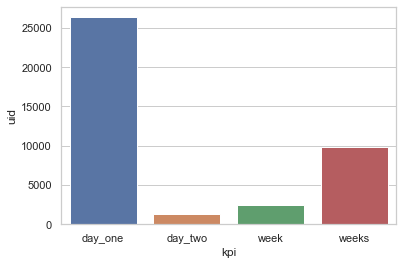

In [195]:
buy_table['buy_month'] = buy_table['buy ts'].astype('datetime64[M]')
buy_table['first_month_buy'] = buy_table['first_buy'].astype('datetime64[M]')

kpi_group = buy_table.groupby('kpi').agg({'uid': 'nunique'}).reset_index()
print(kpi_group)
sns.barplot(data=kpi_group,x='kpi',y='uid')

source__id        1         2         3         4         5     7        9   \
kpi                                                                           
day_one     13372.33  14997.65  27935.88  29261.21  24011.12  1.22  2855.37   
day_two      1047.19    956.97   1203.74   1463.25    768.73   NaN   147.24   
week         2457.49   2360.44   2431.42   3175.60   1885.24   NaN   440.34   
weeks       23742.70  44865.46  13004.16  16646.78  16000.87   NaN  3104.31   

source__id       10  
kpi                  
day_one     2609.60  
day_two      172.80  
week         219.94  
weeks        914.73  


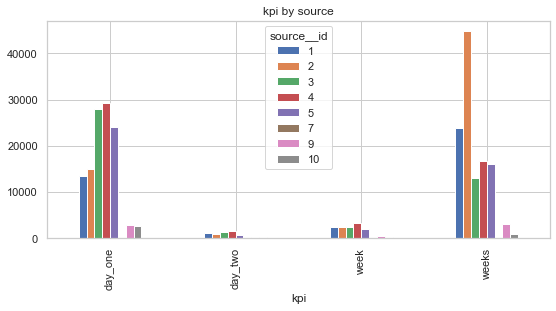

In [198]:
kpi_table = buy_table.pivot_table(index='kpi',columns='source__id',values='revenue',aggfunc='sum')
print(kpi_table)
kpi_table.plot(kind='bar',figsize=(9,4)).set(title='kpi by source');

# KPI
- most of the users make an order in the same day that they first enter the app

- and there are also users who order after the firs week since their first day

In [199]:
buy_table['year'] = buy_table['first_buy'].dt.year
buy_table['month'] = buy_table['first_buy'].dt.month
orders_per_user = buy_table.groupby(['year', 'month']).agg({'uid': ['count', 'nunique']})
orders_per_user.columns = ['n_sessions', 'n_users']
orders_per_user['orders_per_user'] = (orders_per_user['n_sessions'] / orders_per_user['n_users'])
orders_per_user 

n_sessions  n_users  orders_per_user
year month                                      
2017 6            4438     2023         2.193772
     7            2910     1923         1.513261
     8            2188     1370         1.597080
     9            3878     2581         1.502518
     10           6005     4340         1.383641
     11           5900     4081         1.445724
     12           5894     4383         1.344741
2018 1            4308     3373         1.277201
     2            4470     3651         1.224322
     3            4484     3533         1.269176
     4            2690     2276         1.181898
     5            3249     2988         1.087349

In [200]:
print('everge orders number per user',orders_per_user['orders_per_user'].mean())
print('everge session per month',orders_per_user['n_sessions'].mean())

everge orders number per user 1.4183903122799084
everge session per month 4201.166666666667


- orders by time:per user 1.41,per month 4201

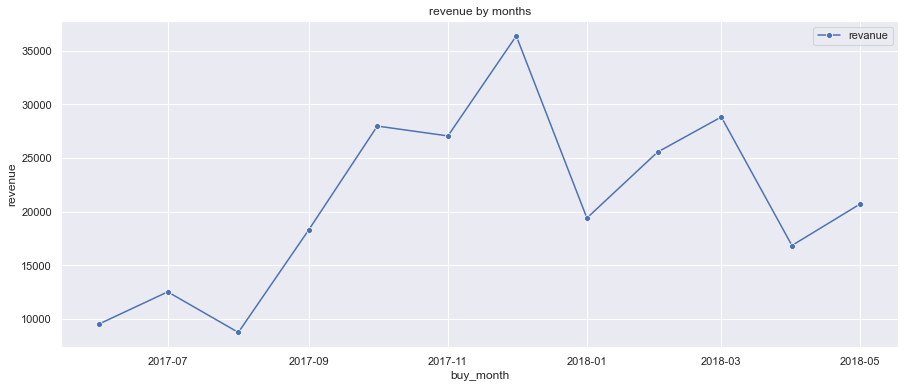

In [203]:
# plot shows revenue by months 
months_group = buy_table.groupby(['buy_month']).agg({'revenue': 'sum'}).reset_index()
sns.set_style("darkgrid")
plt.figure(figsize=(15,6))
sns.lineplot(data=months_group, x='buy_month',ci=41,y='revenue',label='revanue', marker="o").set(title='revenue by months');

In [204]:
cohort_grouped = buy_table.groupby(['first_month_buy','buy_month']).agg(
    {'uid': 'nunique',  'revenue': 'sum'}
).reset_index()
cohort_grouped 

,first_month_buy,buy_month,uid,revenue
0,2017-06-01,2017-06-01,2023,9557.49
1,2017-06-01,2017-07-01,61,981.82
2,2017-06-01,2017-08-01,50,885.34
3,2017-06-01,2017-09-01,54,1931.30
4,2017-06-01,2017-10-01,88,2068.58
...,...,...,...,...
73,2018-03-01,2018-04-01,90,1063.05
74,2018-03-01,2018-05-01,58,1114.87
75,2018-04-01,2018-04-01,2276,10600.69
76,2018-04-01,2018-05-01,69,1209.92


In [206]:
cohort_grouped['mean_'] = cohort_grouped['revenue'] / cohort_grouped['uid'] 
print('the average purchase size is:',cohort_grouped['mean_'].mean())

the average purchase size is: 14.87861333568867


In [207]:
cohort_grouped['life_time'] = cohort_grouped['buy_month'] - cohort_grouped['first_month_buy']

In [208]:
cohort_grouped['life_time'] =  (cohort_grouped['life_time'] / np.timedelta64(1, 'M')).round().astype('int')

In [209]:
cohort_grouped['buy_month'] = cohort_grouped['buy_month'].dt.strftime('%Y-%m')

In [210]:
cohort_grouped

,first_month_buy,buy_month,uid,revenue,mean_,life_time
0,2017-06-01,2017-06,2023,9557.49,4.724414,0
1,2017-06-01,2017-07,61,981.82,16.095410,1
2,2017-06-01,2017-08,50,885.34,17.706800,2
3,2017-06-01,2017-09,54,1931.30,35.764815,3
4,2017-06-01,2017-10,88,2068.58,23.506591,4
...,...,...,...,...,...,...
73,2018-03-01,2018-04,90,1063.05,11.811667,1
74,2018-03-01,2018-05,58,1114.87,19.221897,2
75,2018-04-01,2018-04,2276,10600.69,4.657597,0
76,2018-04-01,2018-05,69,1209.92,17.535072,1


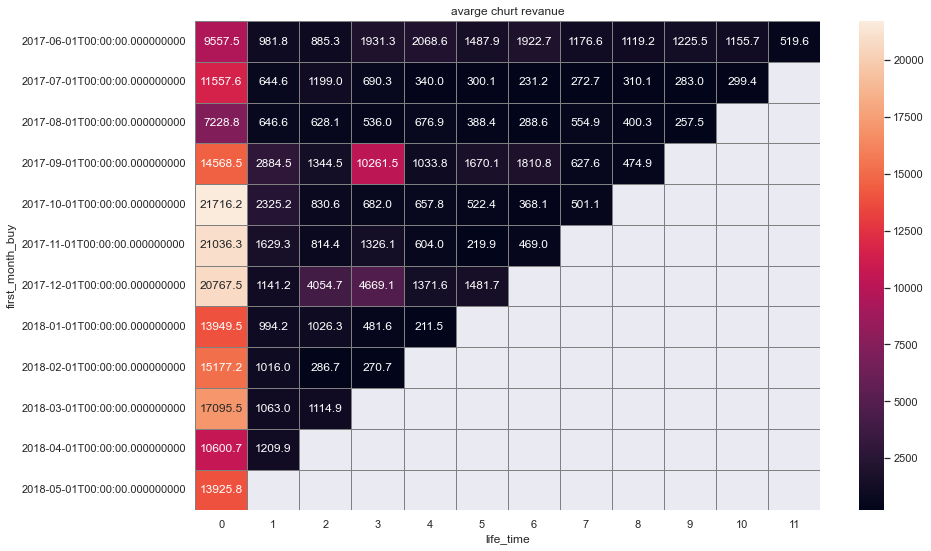

In [212]:
user_pivot = cohort_grouped.pivot_table(index='first_month_buy',columns='life_time',values='revenue',aggfunc='mean',)
plt.figure(figsize=(14, 9))
plt.title('Average customer purchase size')
sns.heatmap(
    user_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray',
).set(title='avarge churt revanue');

-  the average purchase size is 14.7

- the everge purchase is decreasing over time

In [214]:
us_grouped = buy_table.groupby(['first_month_buy']).agg(
    {'uid': 'nunique'}
).reset_index()
us_grouped.columns = ['first_month_buy', 'u_buyers'] 

# ltv

In [215]:
ltv_group = pd.merge(cohort_grouped, us_grouped, on='first_month_buy') 

In [216]:
ltv_group['ltv'] = ltv_group['revenue'] / ltv_group['u_buyers']

final = ltv_group.pivot_table(
    index='first_month_buy', columns='life_time', values='ltv', aggfunc='mean'
).round(2)

final.fillna('') 

life_time,0,1,2,3,4,5,6,7,8,9,10,11
first_month_buy,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


In [217]:
ltv_= final.sum(axis=1).reset_index()
ltv_.columns=['first_month_buy','ltv']
ltv_

,first_month_buy,ltv
0,2017-06-01,11.88
1,2017-07-01,8.40
2,2017-08-01,8.47
3,2017-09-01,13.43
4,2017-10-01,6.36
5,2017-11-01,6.38
6,2017-12-01,7.65
7,2018-01-01,4.93
8,2018-02-01,4.59
9,2018-03-01,5.46


# expenses

In [218]:
expenses.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [219]:
expenses.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [220]:
print(expenses['costs'].sum())
buy_table['revenue'].sum()

329131.62


252053.78000000003

In [221]:
count_group = expenses.groupby('source_id').agg({'costs': 'count'}).reset_index()
count_group   

,source_id,costs
0,1,363
1,2,363
2,3,363
3,4,363
4,5,364
5,9,363
6,10,363


In [222]:
source_group = expenses.groupby('source_id').agg({'costs': 'sum'}).reset_index()
source_group   

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [223]:
source_group['costs'].mean()

47018.80285714285

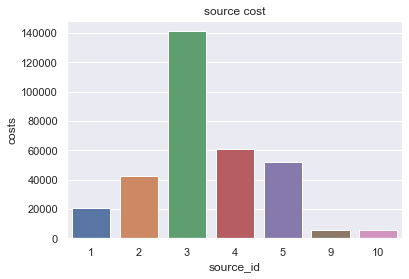

In [225]:
sns.barplot(data=source_group,x='source_id',y='costs').set(title='source cost');

In [226]:
expenses['month'] = expenses['dt'].astype('datetime64[M]')

In [227]:
month_group = expenses.groupby(['month']).agg({'costs': 'sum'}).reset_index()
month_group.columns = ['first_month_buy', 'costs']
month_group

,first_month_buy,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


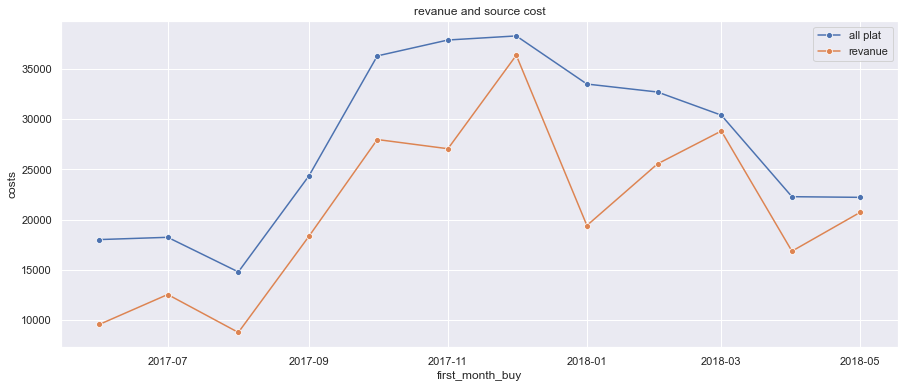

In [230]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,6))
sns.lineplot(data=month_group, x='first_month_buy',ci=41,y='costs',label='all plat', marker="o")
sns.lineplot(data=months_group, x='buy_month',ci=41,y='revenue',label='revanue', marker="o").set(title='revanue and source cost');

-  source  3 is the leading in cost after him are 5,4

- There is a correlation between the cost of platforms and the increase in sales 

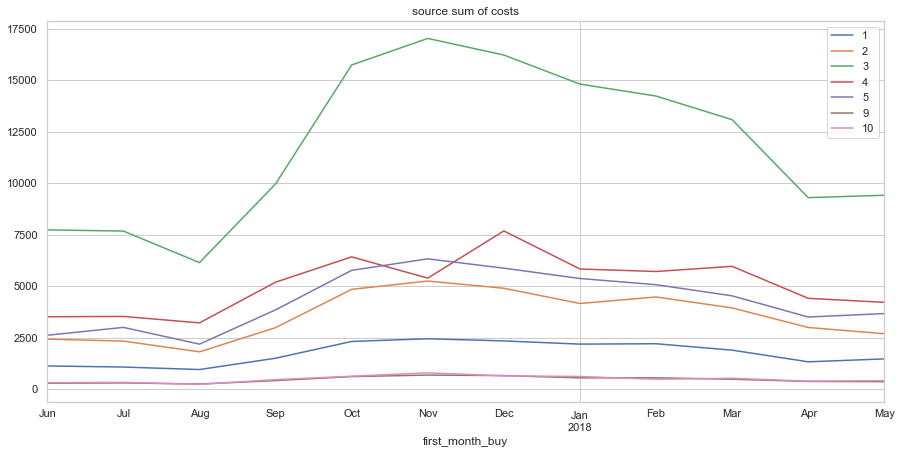

In [232]:
def gr(x):
    expenses1 = expenses.query('source_id == {}'.format(x))
    month_group = expenses1.groupby(['month','source_id']).agg({'costs': 'sum'}).reset_index()
    month_group.columns = ['first_month_buy','id', 'costs']
    month_group.plot(x='first_month_buy',y='costs' ,kind='line',label=x,ax=ax).set(title='source sum of costs')
sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
ax =plt.gca()
gr('1')
gr('2')
gr('3')
gr('4')
gr('5')
gr('9')
gr('10')

# cac


In [234]:
def platform(x):
    expenses1 = expenses.query('source_id == {}'.format(x))
    month_group_ = expenses1.groupby('month').agg({'costs': 'sum'}).reset_index()
    month_group_.columns = ['first_month_buy', 'costs']    
    ca = pd.merge(us_grouped, month_group_ ,on='first_month_buy').reset_index()
    cac_all = pd.merge(ca, ltv_,on='first_month_buy')
    cac_all['cac'] = cac_all['costs'] / cac_all['u_buyers']
    print('source_id,',x)
    print(cac_all['cac'].sum())
platform('1')
platform('2')
platform('3')
platform('4')
platform('5')
platform('9')
platform('10')

source_id, 1
6.92011890781482
source_id, 2
14.201236431168521
source_id, 3
46.88037161252686
source_id, 4
20.813924529883344
source_id, 5
17.187401358331662
source_id, 9
1.8335136183026677
source_id, 10
1.931721051762651


In [236]:
month_group_ = expenses.groupby('month').agg({'costs': 'sum'}).reset_index()
month_group_.columns = ['first_month_buy', 'costs']    
cac_m = pd.merge(ltv_group, month_group_,on='first_month_buy')
cac_m['cac'] = cac_m['costs'] / cac_m['u_buyers']
cac_m.head()

,first_month_buy,buy_month,uid,revenue,mean_,life_time,u_buyers,ltv,costs,cac
0,2017-06-01,2017-06,2023,9557.49,4.724414,0,2023,4.724414,18015.0,8.905091
1,2017-06-01,2017-07,61,981.82,16.095410,1,2023,0.485329,18015.0,8.905091
2,2017-06-01,2017-08,50,885.34,17.706800,2,2023,0.437637,18015.0,8.905091
3,2017-06-01,2017-09,54,1931.30,35.764815,3,2023,0.954671,18015.0,8.905091
4,2017-06-01,2017-10,88,2068.58,23.506591,4,2023,1.022531,18015.0,8.905091


In [239]:
# all sources romi
cac_m['romi'] = cac_m['ltv'] / cac_m['cac']
output = cac_m.pivot_table( index='first_month_buy', columns='life_time', values='romi', aggfunc='mean')   
output.cumsum(axis=1).round(2).fillna('') 

life_time,0,1,2,3,4,5,6,7,8,9,10,11
first_month_buy,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [240]:
output.cumsum(axis=1).mean(axis=0).reset_index()

,life_time,0
0,0,0.540816
1,1,0.581985
2,2,0.631069
3,3,0.719740
4,4,0.782946
5,5,0.859876
6,6,0.896819
7,7,0.969951
8,8,1.053871
9,9,0.964488


- this is This is a general calculation of Rumi and it can be seen that in the 10th month the investment in advertising was returned

the 1 source id everage pay off
1 cac sum 434.3694908192907
    life_time         0
0           0  1.138824
1           1  1.324267
2           2  1.445825
3           3  1.610245
4           4  1.827521
5           5  2.054927
6           6  2.410294
7           7  2.673660
8           8  3.010948
9           9  3.223722
10         10  4.250457
11         11  7.032871
AxesSubplot(0.125,0.125;0.775x0.755)
-----------
the 2 source id everage pay off
2 cac sum 799.6484411834879
    life_time         0
0           0  0.686117
1           1  0.770816
2           2  0.918439
3           3  1.426404
4           4  1.650734
5           5  1.954350
6           6  1.896881
7           7  2.186449
8           8  2.481570
9           9  1.311872
10         10  1.716319
11         11  1.819909
AxesSubplot(0.125,0.125;0.775x0.755)
-----------
the 3 source id everage pay off
3 cac sum 1245.7809907196909
    life_time         0
0           0  0.286608
1           1  0.293780
2           2  0.305410
3

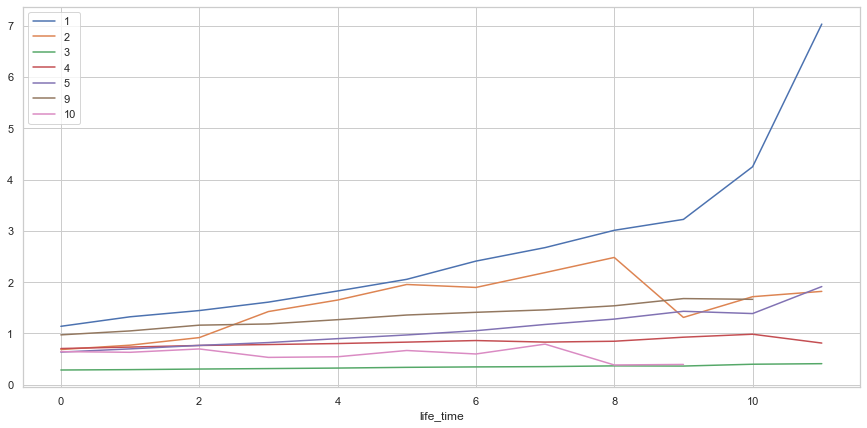

In [241]:
def gr(x):
    buy_table_ = buy_table.query('source__id == {}'.format(x))

    cohort_grouped = buy_table_.groupby(['first_month_buy','buy_month']).agg({'uid': 'nunique',  'revenue': 'sum'}).reset_index()
    cohort_grouped['life_time'] = cohort_grouped['buy_month'] - cohort_grouped['first_month_buy']
    cohort_grouped['life_time'] =  (cohort_grouped['life_time'] / np.timedelta64(1, 'M')).round().astype('int')
    cohort_grouped['buy_month'] = cohort_grouped['buy_month'].dt.strftime('%Y-%m')
    us_grouped = buy_table_.groupby(['first_month_buy']).agg({'uid': 'nunique'}).reset_index()   
    us_grouped.columns = ['first_month_buy', 'u_buyers'] 
    ltv_group = pd.merge(cohort_grouped, us_grouped, on='first_month_buy') 
    ltv_group['ltv'] = ltv_group['revenue'] / ltv_group['u_buyers']
    final = ltv_group.pivot_table( index='first_month_buy', columns='life_time', values='ltv', aggfunc='mean').round(2).fillna('')
    
    expenses_ = expenses.query('source_id == {}'.format(x))

    month_group_ = expenses_.groupby('month').agg({'costs': 'sum'}).reset_index()
    month_group_.columns = ['first_month_buy', 'costs']    
    cac_m = pd.merge(ltv_group, month_group_,on='first_month_buy')
    cac_m['cac'] = cac_m['costs'] / cac_m['u_buyers']
    cac_m['romi'] = cac_m['ltv'] / cac_m['cac']
    output = cac_m.pivot_table( index='first_month_buy', columns='life_time', values='romi', aggfunc='mean')   
    output.cumsum(axis=1).round(2).fillna('')
    output1=output.cumsum(axis=1).mean(axis=0).reset_index()
    print('the',x,'source id everage pay off')
    print(x,'cac sum',cac_m['cac'].sum())
    print(output1)
    print(output1.plot(x='life_time',y=0 ,kind='line',label=x,ax=ax));
plt.figure(figsize=(15,7))
ax =plt.gca()
gr('1')
print('-----------')
gr('2')
print('-----------')
gr('3')
print('-----------')
gr('4')
print('-----------')
gr('5')
print('-----------')
gr('9')
print('-----------')
gr('10')

- romi by platforms

- platform 1 has the best ratio  The costs of advertising are reimbursed from the first month also 2,5,9 have agood ratio

- platforms 4,3,10 arent close to repay their cost

# final conclusion:

- after opening the data and check there are no duplicates and missing values i add to the visits table the first date column which is the first time auser enter the proudect and also ad month day week columns,in the orders table add anew column with map source id By a dictionary I created from both columns of the visits table (uid,source id)

- I calculated retention and sticki rates and also churn rate to see how many customers return to the  product ,at the order table I calculated how many orders there are for each user and what is the average order amount and also ltv